In [1]:
import pandas as pd
import os
import io 
import cv2
import numpy as np
from matplotlib import pyplot as plt

#Crop Eye

In [2]:
from face_detector import MTCNNFaceDetector
import tensorflow as tf
from keras import backend as K

<function Network.conv at 0x7f4a4e2fb8c0>
<function Network.prelu at 0x7f4a4e2fbb90>
<function Network.max_pool at 0x7f4a4e2fba70>
<function Network.fc at 0x7f4a4e2fbf80>
<function Network.softmax at 0x7f4a4e2ff200>


In [ ]:
mtcnn_weights_dir = "./"
fd = MTCNNFaceDetector(sess=tf.compat.v1.keras.backend.get_session(), model_path=mtcnn_weights_dir)

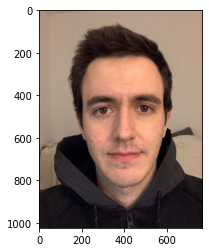

In [4]:
img_path = "/content/rob.jpeg"
input_img = cv2.imread(img_path)[..., ::-1]
plt.imshow(input_img)

In [5]:
face, lms = fd.detect_face(input_img) # assuming there is only one face in input image
assert len(face) >= 1, "No face detected"

In [6]:
left_eye_im, right_eye_im = fd.cropImage(input_img,lms)

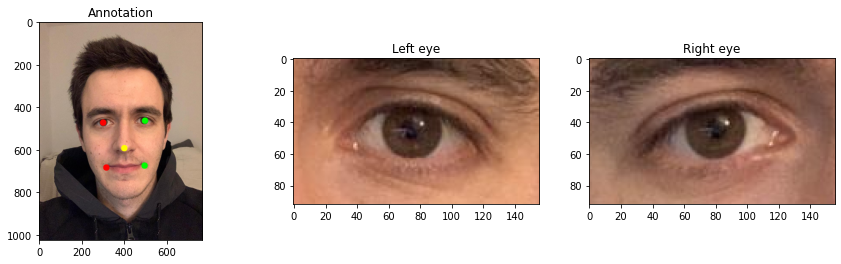

In [8]:
left_eye_xy = np.array([lms[6], lms[1]])
right_eye_xy = np.array([lms[5], lms[0]])
nouse = np.array([lms[7], lms[2]])
right_mouth=np.array([lms[8], lms[3]])
left_mouth=np.array([lms[9], lms[4]])

dist_eyes = np.linalg.norm(left_eye_xy - right_eye_xy)
eye_bbox_w = (dist_eyes / 1.25)
eye_bbox_h = (eye_bbox_w *0.6)

# left_eye_im = input_img[
#     int(left_eye_xy[0]-eye_bbox_h//2):int(left_eye_xy[0]+eye_bbox_h//2),
#     int(left_eye_xy[1]-eye_bbox_w//2):int(left_eye_xy[1]+eye_bbox_w//2), :]

#np.append(shapes, left_eye_im.shape, axis=1)
#print(shapes)
#left_eye_im = left_eye_im[:,::-1,:] # No need for flipping left eye for iris detection

# right_eye_im = input_img[
#     int(right_eye_xy[0]-eye_bbox_h//2):int(right_eye_xy[0]+eye_bbox_h//2),
#     int(right_eye_xy[1]-eye_bbox_w//2):int(right_eye_xy[1]+eye_bbox_w//2), :]

plt.figure(figsize=(15,4))
draw = input_img.copy()
for i, lm in enumerate([left_eye_xy, right_eye_xy]):
    draw = cv2.circle(draw, (int(lm[1]), int(lm[0])), 15, (255*i,255*(1-i),0), -1)
draw = cv2.circle(draw, (int(nouse[1]), int(nouse[0])), 15, (255,255*(1-0),0), -1)
for i, lm in enumerate([left_mouth, right_mouth]):
    draw = cv2.circle(draw, (int(lm[1]), int(lm[0])), 15, (255*i,255*(1-i),0), -1)

plt.subplot(1,3,1)
plt.title('Annotation')
plt.imshow(draw)
plt.subplot(1,3,2)
plt.title('Left eye')
plt.imshow(left_eye_im)
plt.subplot(1,3,3)
plt.title('Right eye')
plt.imshow(right_eye_im)

#Crop Iris

In [9]:
from elg_keras import KerasELG
model = KerasELG()
model.net.load_weights("./elg_keras.h5")

In [10]:
inp_left = cv2.cvtColor(left_eye_im, cv2.COLOR_RGB2GRAY)
inp_left = cv2.equalizeHist(inp_left)
inp_left = cv2.resize(inp_left, (180,108))[np.newaxis, ..., np.newaxis]

inp_right = cv2.cvtColor(right_eye_im, cv2.COLOR_RGB2GRAY)
inp_right = cv2.equalizeHist(inp_right)
inp_right = cv2.resize(inp_right, (180,108))[np.newaxis, ..., np.newaxis]

In [11]:
input_array = np.concatenate([inp_left, inp_right], axis=0)
pred_left, pred_right = model.net.predict(input_array/255 * 2 - 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
lms = model._calculate_landmarks(pred)

In [14]:
def draw_pupil(im, inp_im, lms):
    draw = im.copy()
    #print(draw.shape)
    draw = cv2.resize(draw, (inp_im.shape[2], inp_im.shape[1]))
    stroke = inp_im.shape[1] // 30
    for i, lm in enumerate(np.squeeze(lms)):

        x, y = int(lm[0]*3), int(lm[1]*3)
        if i < 8:
            draw = cv2.circle(draw, (x, y), stroke, (125,255,125), -1)
        elif 8 <= i < 16:
            draw = cv2.circle(draw, (x, y), stroke, (125,125,255), -1)         

    return draw

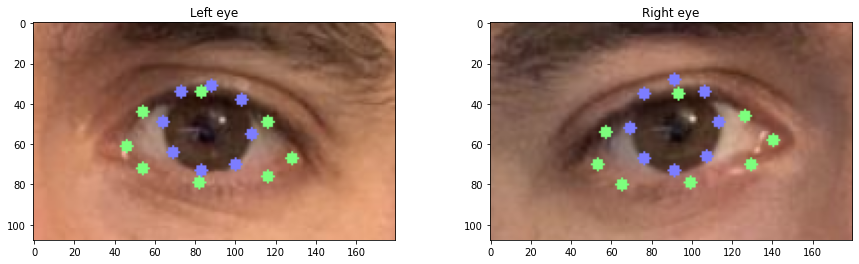

In [15]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.title("Left eye")
lms_left = model._calculate_landmarks(pred_left)
result_left = draw_pupil(left_eye_im, inp_left, lms_left)
plt.imshow(result_left)
plt.subplot(1,2,2)
plt.title("Right eye")
lms_right = model._calculate_landmarks(pred_right)
result_right = draw_pupil(right_eye_im, inp_right, lms_right)
plt.imshow(result_right)

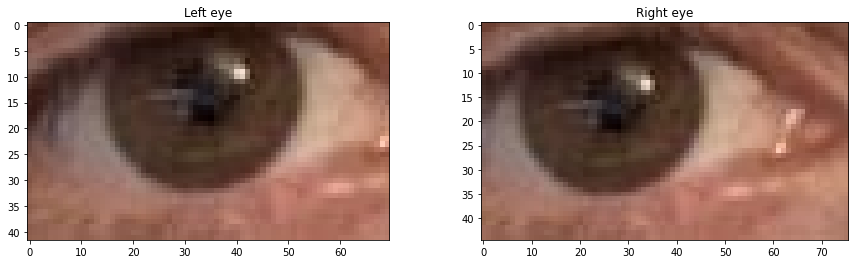

In [18]:
#plt.imshow(right_eye_im)
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.title("Left eye")
cropped_left= right_eye_im[int(lms_left[0][10][1] * 3):int(lms_left[0][14][1] * 3),
                int(lms_left[0][0][0] * 3):int(lms_left[0][5][0] * 3)]
plt.imshow(cropped_left)

plt.subplot(1,2,2)
plt.title("Right eye")
cropped_right= right_eye_im[int(lms_right[0][10][1] * 3):int(lms_right[0][14][1] * 3),
                int(lms_right[0][0][0] * 3):int(lms_right[0][5][0] * 3)]
plt.imshow(cropped_right)

In [ ]:
eye=cv2.resize(img[:,:,::-1], (180, 108))
print(eye.shape)
print(eye[int(lms[0][10][1] * 3):int(lms[0][14][1] * 3),
          int(lms[0][0][0] * 3):int(lms[0][5][0] * 3)].shape)
final_crop= eye[int(lms[0][10][1] * 3):int(lms[0][14][1] * 3),
                int(lms[0][0][0] * 3):int(lms[0][5][0] * 3)]
#final_crop= left_eye_im[:10:100,50:100]
plt.imshow(final_crop)